In [1]:
from pycm import *
from matplotlib import pyplot as plt
from easydict import EasyDict as edict
from module.class_names import class_names
from torchvision import transforms
from torch.nn import functional as F
from module.models import create_model
from module.utils import metrics_report_to_df, save_plot_cm, prec_score, \
                        recc_score, acc_score, fone_score, classification_reports, set_seeds, \
                        precision_recall_fscore_support
from pycm import *
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import os
import time
import torch
import numpy as np
import yaml
import glob as glob
import cv2
import argparse

In [2]:
class_names

['AM General Hummer SUV 2000',
 'Acura Integra Type R 2001',
 'Acura RL Sedan 2012',
 'Acura TL Sedan 2012',
 'Acura TL Type-S 2008',
 'Acura TSX Sedan 2012',
 'Acura ZDX Hatchback 2012',
 'Aston Martin V8 Vantage Convertible 2012',
 'Aston Martin V8 Vantage Coupe 2012',
 'Aston Martin Virage Convertible 2012',
 'Aston Martin Virage Coupe 2012',
 'Audi 100 Sedan 1994',
 'Audi 100 Wagon 1994',
 'Audi A5 Coupe 2012',
 'Audi R8 Coupe 2012',
 'Audi RS 4 Convertible 2008',
 'Audi S4 Sedan 2007',
 'Audi S4 Sedan 2012',
 'Audi S5 Convertible 2012',
 'Audi S5 Coupe 2012',
 'Audi S6 Sedan 2011',
 'Audi TT Hatchback 2011',
 'Audi TT RS Coupe 2012',
 'Audi TTS Coupe 2012',
 'Audi V8 Sedan 1994',
 'BMW 1 Series Convertible 2012',
 'BMW 1 Series Coupe 2012',
 'BMW 3 Series Sedan 2012',
 'BMW 3 Series Wagon 2012',
 'BMW 6 Series Convertible 2007',
 'BMW ActiveHybrid 5 Sedan 2012',
 'BMW M3 Coupe 2012',
 'BMW M5 Sedan 2010',
 'BMW M6 Convertible 2010',
 'BMW X3 SUV 2012',
 'BMW X5 SUV 2007',
 'BMW X6

In [3]:
init = set_seeds()
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(f"Computation device: {device}")

Computation device: cuda:0


In [4]:
def transform(image):
    transformation = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                    std=[0.229, 0.224, 0.225])
            ])
    return transformation(image)

In [5]:
color_path = f"../Inference/best_models/color.pth" 
pku_path = f"../Inference/best_models/pku.pth" 
stanford_path = f"../Inference/best_models/stanford.pth" 

In [6]:
stanford = create_model(model_name = 'efficientnet_v2_s' , num_classes = 196).to(device)
stanford.eval()

[INFO]: Freezing hidden layers...


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [7]:
print(stanford.load_state_dict(torch.load(stanford_path, 
                                    map_location=device)['model_state_dict'], 
                                   ))

<All keys matched successfully>


In [8]:
test_path = '../Dataset/Stanford-Cars/val/*/*.jpg'
test_images = glob.glob(test_path, recursive=True)
len(test_images)

8041

In [9]:
from tqdm import tqdm

y_true = []
y_pred  = []
t0 = time.time()
for image_path in tqdm(test_images):
    image = cv2.imread(image_path)
    actual_class_name = image_path.split(os.path.sep)[-2]
    original_image = image.copy()

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width, channel = original_image.shape

    image_tensor = transform(image)
    image_tensor = image_tensor.unsqueeze(0).to(device)

    start_time = time.time()

    with torch.no_grad():      
        outputs = stanford(image_tensor)
      
    end_time = time.time()

    probs = F.softmax(outputs, dim=1)
    conf, classes = torch.max(probs, 1)
    conf_score = float(conf.item())
    class_idx = int(classes.item())
    pred_class_name = str(class_names[int(class_idx)])

    y_true.append(actual_class_name)
    y_pred.append(pred_class_name)

#     print(f"Actual: {actual_class_name} / Prediction: {pred_class_name} ({conf_score})")
#     print(f"Inference Time: {(end_time - start_time)*1000 :.3f} ms.")

100%|██████████| 8041/8041 [58:26<00:00,  2.29it/s]  


In [10]:
print(f"Precision score (weighted): {prec_score(y_true, y_pred, class_names):.4f}")
print(f"Recall score (weighted): {recc_score(y_true, y_pred, class_names):.4f}")
print(f"Accuracy score (weighted): {acc_score(y_true, y_pred):.4f}")
print(f"F1 Score score (weighted): {fone_score(y_true, y_pred, class_names):.4f}")
# print(f"PRSF: {precision_recall_fscore_support(y_true, y_pred)}")
print(f"Clssification report:\n")
print(classification_reports(y_true, y_pred, class_names))

Precision score (weighted): 0.8973
Recall score (weighted): 0.8919
Accuracy score (weighted): 0.8919
F1 Score score (weighted): 0.8911
Clssification report:

                                                        precision    recall  f1-score   support

                            AM General Hummer SUV 2000       0.88      1.00      0.94        44
                             Acura Integra Type R 2001       0.93      0.95      0.94        44
                                   Acura RL Sedan 2012       0.74      0.88      0.80        32
                                   Acura TL Sedan 2012       0.81      0.91      0.86        43
                                  Acura TL Type-S 2008       1.00      0.98      0.99        42
                                  Acura TSX Sedan 2012       1.00      0.80      0.89        40
                              Acura ZDX Hatchback 2012       0.89      0.85      0.87        39
              Aston Martin V8 Vantage Convertible 2012       0.74      0.

In [11]:
cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix

array([[44,  0,  0, ...,  0,  0,  0],
       [ 0, 42,  0, ...,  0,  0,  0],
       [ 0,  0, 28, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 39,  0,  0],
       [ 0,  0,  0, ...,  0, 41,  0],
       [ 0,  0,  0, ...,  0,  0, 37]])

In [12]:
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)
FP, FN, TP, TN

(array([ 6.,  3., 10.,  9.,  0.,  0.,  4., 13.,  6.,  0.,  5., 22.,  3.,
        13.,  3., 12.,  9., 10.,  6.,  9.,  5., 23.,  9., 11.,  4.,  0.,
         3.,  5.,  3.,  1.,  5.,  7.,  6., 18.,  1.,  0.,  2.,  0.,  0.,
         2., 16., 14.,  5.,  4.,  4.,  7.,  1.,  4.,  8.,  5.,  2.,  3.,
         3.,  9.,  0.,  2.,  9.,  5.,  6.,  4., 18.,  0.,  6.,  4.,  1.,
         2.,  4., 18.,  4., 14., 11.,  1.,  6.,  0.,  0.,  2.,  2.,  3.,
         0.,  1.,  1.,  2., 16., 11.,  2.,  1.,  2.,  3.,  5.,  1.,  3.,
         0.,  1.,  0.,  3.,  5.,  2.,  1.,  1.,  7.,  6.,  4.,  2.,  4.,
         1.,  0.,  5.,  4.,  4.,  3.,  2.,  2.,  6.,  3.,  4.,  2.,  4.,
         2.,  1., 23.,  1.,  3.,  0.,  1., 10.,  2.,  4.,  2.,  6.,  7.,
         2.,  1.,  7.,  3., 10.,  0.,  3.,  2.,  2.,  7.,  4.,  2.,  5.,
         5.,  6.,  3.,  1.,  5.,  0.,  0.,  6.,  6.,  6.,  2.,  2.,  0.,
         1.,  4.,  1.,  2.,  0.,  3.,  6.,  5.,  2., 11.,  0.,  6.,  3.,
         1.,  0.,  0., 13.,  2.,  3.,  3.,  5.,  1.

In [13]:
ACC = (TP+TN)/(TP+FP+FN+TN)
sum(ACC)/196

0.9988972333119291

In [14]:
P = TP/(TP+FP)
sum(P) / 196

0.896133499936859

In [15]:
R = TP/(TP+FN)
sum(R) / 196

0.8905972139927477

In [16]:
cm = ConfusionMatrix(actual_vector=y_true, predict_vector=y_pred)

In [17]:
cm.classes

['AM General Hummer SUV 2000',
 'Acura Integra Type R 2001',
 'Acura RL Sedan 2012',
 'Acura TL Sedan 2012',
 'Acura TL Type-S 2008',
 'Acura TSX Sedan 2012',
 'Acura ZDX Hatchback 2012',
 'Aston Martin V8 Vantage Convertible 2012',
 'Aston Martin V8 Vantage Coupe 2012',
 'Aston Martin Virage Convertible 2012',
 'Aston Martin Virage Coupe 2012',
 'Audi 100 Sedan 1994',
 'Audi 100 Wagon 1994',
 'Audi A5 Coupe 2012',
 'Audi R8 Coupe 2012',
 'Audi RS 4 Convertible 2008',
 'Audi S4 Sedan 2007',
 'Audi S4 Sedan 2012',
 'Audi S5 Convertible 2012',
 'Audi S5 Coupe 2012',
 'Audi S6 Sedan 2011',
 'Audi TT Hatchback 2011',
 'Audi TT RS Coupe 2012',
 'Audi TTS Coupe 2012',
 'Audi V8 Sedan 1994',
 'BMW 1 Series Convertible 2012',
 'BMW 1 Series Coupe 2012',
 'BMW 3 Series Sedan 2012',
 'BMW 3 Series Wagon 2012',
 'BMW 6 Series Convertible 2007',
 'BMW ActiveHybrid 5 Sedan 2012',
 'BMW M3 Coupe 2012',
 'BMW M5 Sedan 2010',
 'BMW M6 Convertible 2010',
 'BMW X3 SUV 2012',
 'BMW X5 SUV 2007',
 'BMW X6

In [18]:
cm

pycm.ConfusionMatrix(classes: ['AM General Hummer SUV 2000', 'Acura Integra Type R 2001', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012', 'Acura TL Type-S 2008', 'Acura TSX Sedan 2012', 'Acura ZDX Hatchback 2012', 'Aston Martin V8 Vantage Convertible 2012', 'Aston Martin V8 Vantage Coupe 2012', 'Aston Martin Virage Convertible 2012', 'Aston Martin Virage Coupe 2012', 'Audi 100 Sedan 1994', 'Audi 100 Wagon 1994', 'Audi A5 Coupe 2012', 'Audi R8 Coupe 2012', 'Audi RS 4 Convertible 2008', 'Audi S4 Sedan 2007', 'Audi S4 Sedan 2012', 'Audi S5 Convertible 2012', 'Audi S5 Coupe 2012', 'Audi S6 Sedan 2011', 'Audi TT Hatchback 2011', 'Audi TT RS Coupe 2012', 'Audi TTS Coupe 2012', 'Audi V8 Sedan 1994', 'BMW 1 Series Convertible 2012', 'BMW 1 Series Coupe 2012', 'BMW 3 Series Sedan 2012', 'BMW 3 Series Wagon 2012', 'BMW 6 Series Convertible 2007', 'BMW ActiveHybrid 5 Sedan 2012', 'BMW M3 Coupe 2012', 'BMW M5 Sedan 2010', 'BMW M6 Convertible 2010', 'BMW X3 SUV 2012', 'BMW X5 SUV 2007', 'BMW X6 SUV 2

In [19]:
cm.print_matrix()

Predict                                                      AM General Hummer SUV 2000                                   Acura Integra Type R 2001                                    Acura RL Sedan 2012                                          Acura TL Sedan 2012                                          Acura TL Type-S 2008                                         Acura TSX Sedan 2012                                         Acura ZDX Hatchback 2012                                     Aston Martin V8 Vantage Convertible 2012                     Aston Martin V8 Vantage Coupe 2012                           Aston Martin Virage Convertible 2012                         Aston Martin Virage Coupe 2012                               Audi 100 Sedan 1994                                          Audi 100 Wagon 1994                                          Audi A5 Coupe 2012                                           Audi R8 Coupe 2012                                           Audi RS 4 Convertible 20

/opt/conda/lib/python3.8/site-packages/pycm/pycm_obj.py:136: RuntimeWarning: The confusion matrix is a high dimension matrix and won't be demonstrated properly.
If confusion matrix has too many zeros (sparse matrix) you can set `sparse` flag to True in printing functions otherwise by using save_csv method to save the confusion matrix in csv format you'll have better demonstration.
  warn(CLASS_NUMBER_WARNING, RuntimeWarning)


In [20]:
print(cm)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

/opt/conda/lib/python3.8/site-packages/pycm/pycm_obj.py:217: RuntimeWarning: The confusion matrix is a high dimension matrix and won't be demonstrated properly.
If confusion matrix has too many zeros (sparse matrix) you can set `sparse` flag to True in printing functions otherwise by using save_csv method to save the confusion matrix in csv format you'll have better demonstration.
  warn(CLASS_NUMBER_WARNING, RuntimeWarning)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

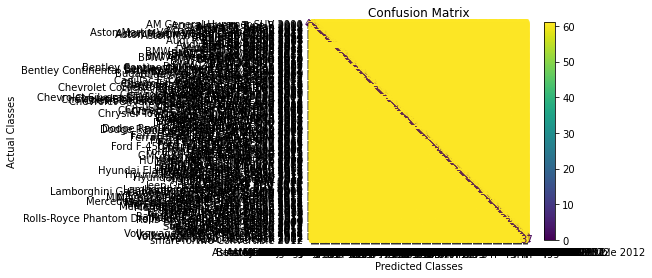

In [21]:
cm.plot(cmap=plt.cm.viridis, number_label=True, plot_lib="matplotlib")

In [22]:
TP  = sum(cm.TP.values())
TP

7172

In [23]:
acc = 7172/8041
acc

0.8919288645690835

In [24]:
TN  = sum(cm.TN.values())
TN

1567126

In [25]:
FP = sum(cm.FP.values())
FP

869

In [26]:
FN  = sum(cm.FN.values())
FN

869

In [27]:
acc = (TP) / (8041)
acc

0.8919288645690835

In [28]:
P = TP/(TP+FP)
P

0.8919288645690835

In [29]:
R = TP/(TP+FN)
R

0.8919288645690835

In [30]:
F1 = 2 * (P*R)/(P+R)
F1

0.8919288645690836